In [1]:
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler #chuẩn hóa dữ liệu
from keras.callbacks import ModelCheckpoint #lưu lại huấn luyện tốt nhất
from tensorflow.keras.models import load_model #tải mô hình
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import ModelCheckpoint

import random
import tensorflow as tf

#các lớp để xây dựng mô hình
from keras.models import Sequential #đầu vào
from keras.layers import LSTM #học phụ thuộc
from keras.layers import Dropout, BatchNormalization #tránh học tủ
from keras.layers import Dense #đầu ra

#kiểm tra độ chính xác của mô hình
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score


In [2]:
random.seed(42)
np.random.seed(42)
tf.random.set_seed(42)

In [3]:
df_usd = pd.read_parquet("./minio/usd/part-00000-18b834c3-cd6d-42ae-82c3-638999ff6d84-c000.snappy.parquet", engine="pyarrow")
df_usd.head()

,ngay,ma_ngoai_te,ten_ngoai_te,mua_chuyen_khoan,ban
0,2020-02-01,USD,US DOLLAR,23165.0,23305.0
1,2020-02-02,USD,US DOLLAR,23165.0,23305.0
2,2020-02-03,USD,US DOLLAR,23200.0,23340.0
3,2020-02-04,USD,US DOLLAR,23170.0,23310.0
4,2020-02-05,USD,US DOLLAR,23160.0,23300.0


In [4]:
df_usd.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1911 entries, 0 to 1910
Data columns (total 5 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   ngay              1911 non-null   datetime64[ns]
 1   ma_ngoai_te       1911 non-null   object        
 2   ten_ngoai_te      1911 non-null   object        
 3   mua_chuyen_khoan  1911 non-null   float64       
 4   ban               1911 non-null   float64       
dtypes: datetime64[ns](1), float64(2), object(2)
memory usage: 74.8+ KB


In [5]:
df_usd.describe()

,ngay,mua_chuyen_khoan,ban
count,1911,1911.000000,1911.000000
mean,2022-09-13 00:00:00,23666.414443,23934.197279
min,2020-02-01 00:00:00,22480.000000,22745.000000
25%,2021-05-23 12:00:00,22985.000000,23170.000000
50%,2022-09-13 00:00:00,23300.000000,23620.000000
75%,2024-01-03 12:00:00,24390.000000,24730.000000
max,2025-04-25 00:00:00,25835.000000,26195.000000
std,NaN,885.147984,926.810272


In [6]:
print(df_usd.dtypes)

ngay                datetime64[ns]
ma_ngoai_te                 object
ten_ngoai_te                object
mua_chuyen_khoan           float64
ban                        float64
dtype: object


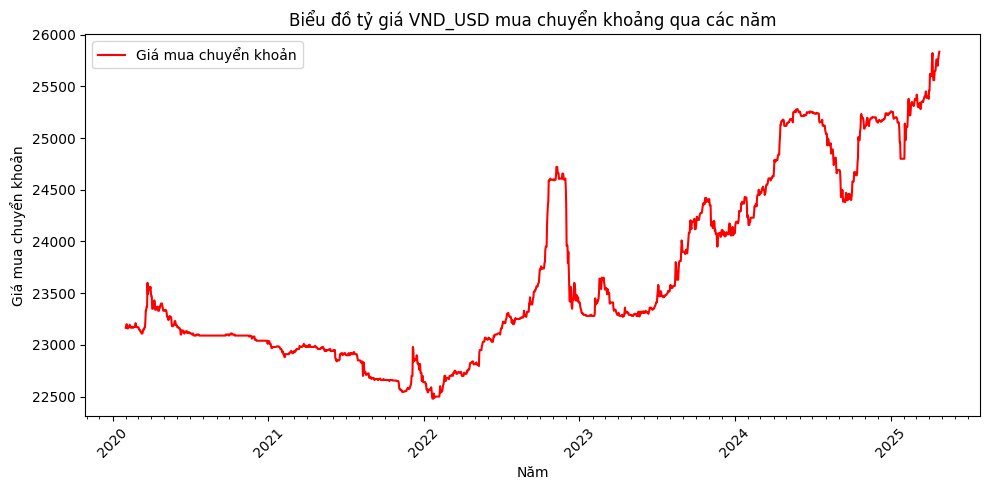

In [7]:
import matplotlib.pyplot as plt
from matplotlib.dates import YearLocator, DateFormatter, MonthLocator

# Vẽ biểu đồ
plt.figure(figsize=(10, 5))
plt.plot(df_usd['ngay'].values, df_usd['mua_chuyen_khoan'].values, label='Giá mua chuyển khoản', color='red')

plt.xlabel('Năm')
plt.ylabel('Giá mua chuyển khoản')
plt.title('Biểu đồ tỷ giá VND_USD mua chuyển khoảng qua các năm')
plt.legend(loc='best')

# Định dạng trục x
plt.gca().xaxis.set_major_locator(YearLocator())
plt.gca().xaxis.set_major_formatter(DateFormatter('%Y'))
plt.gca().xaxis.set_minor_locator(MonthLocator())

plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [8]:
df_usd_ML = pd.DataFrame(df_usd, columns=['ngay','mua_chuyen_khoan'])
df_usd_ML.index = df_usd_ML.ngay
df_usd_ML.drop('ngay', axis = 1, inplace=True)
df_usd_ML.head()

,mua_chuyen_khoan
ngay,
2020-02-01,23165.0
2020-02-02,23165.0
2020-02-03,23200.0
2020-02-04,23170.0
2020-02-05,23160.0


In [9]:
print(df_usd_ML.columns)

Index(['mua_chuyen_khoan'], dtype='object')


In [10]:
data = df_usd_ML.values


In [11]:
data

array([[23165.],
       [23165.],
       [23200.],
       ...,
       [25781.],
       [25814.],
       [25835.]])

In [12]:
#hàm hóa dữ liệu
sc = MinMaxScaler(feature_range=(0,1))

#chuẩn hóa dữ train
scale_data = sc.fit_transform(data)

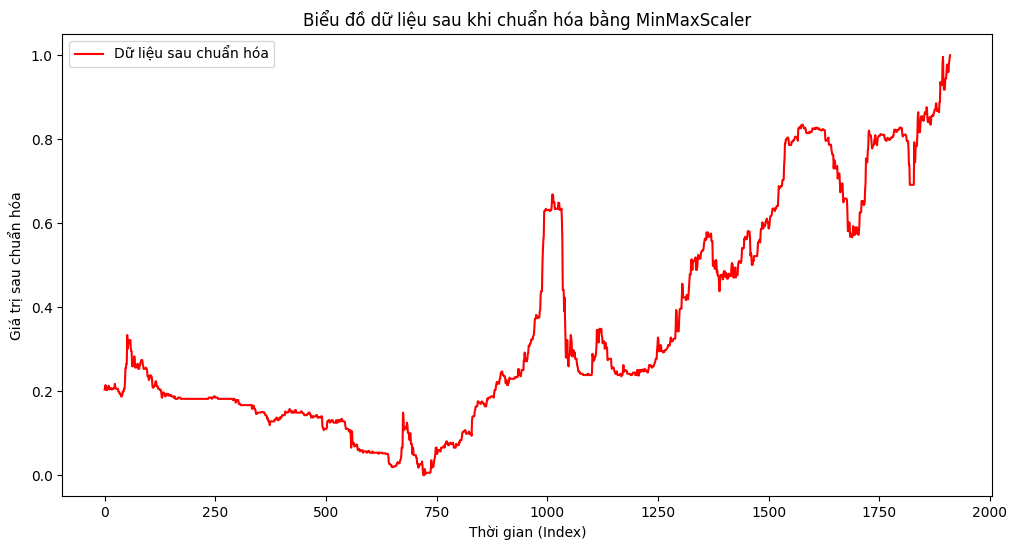

In [13]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))

plt.plot(scale_data, label="Dữ liệu sau chuẩn hóa", color="red")

plt.xlabel("Thời gian (Index)")
plt.ylabel("Giá trị sau chuẩn hóa")
plt.title("Biểu đồ dữ liệu sau khi chuẩn hóa bằng MinMaxScaler")
plt.legend()
plt.show()


In [14]:
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Bidirectional, LSTM, Dense, Dropout

# Chọn window
window_size = 7
X_train, Y_train = [], []

for i in range(len(scale_data) - window_size):
    X_train.append(scale_data[i:i + window_size])
    Y_train.append(scale_data[i + window_size])

X_train = np.array(X_train)
Y_train = np.array(Y_train)

# Phân chia tập dữ liệu thành tập train và test 70 - 30
split_index = int(0.7 * len(X_train))

X_train, X_test = X_train[:split_index], X_train[split_index:]
Y_train, Y_test = Y_train[:split_index], Y_train[split_index:]

# Đảm bảo dữ liệu có đúng shape cho mô hình BiLSTM
X_train = X_train.reshape((X_train.shape[0], window_size, -1))
X_test = X_test.reshape((X_test.shape[0], window_size, -1))

In [15]:
print("X_train shape:", X_train.shape)
print("X_test shape:", X_test.shape)
print("y_train shape:", Y_train.shape)
print("y_test shape:", Y_test.shape)

X_train shape: (1332, 7, 1)
X_test shape: (572, 7, 1)
y_train shape: (1332, 1)
y_test shape: (572, 1)


In [16]:
print("Shape of X_train:", X_train.shape)

Shape of X_train: (1332, 7, 1)


# MODEL

In [17]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, Bidirectional, BatchNormalization

# Xây dựng mô hình BiLSTM
model = Sequential()

# Lớp BiLSTM đầu tiên (return_sequences=True để kết nối lớp tiếp theo)
model.add(Bidirectional(LSTM(units=64, return_sequences=True, input_shape=(X_train.shape[1], 1))))
model.add(BatchNormalization())  # Ổn định dữ liệu đầu ra

# Lớp BiLSTM thứ hai
model.add(Bidirectional(LSTM(units=64)))
model.add(BatchNormalization())

# Dropout để giảm overfitting
model.add(Dropout(0.5))

# Lớp Dense đầu ra
model.add(Dense(1))

# Compile mô hình
model.compile(loss='mean_absolute_error', optimizer='adam')


# huấn luyện mô hình

In [18]:
save_model = "./Model/case_2/BiLSTM/model_7030/save_model.hdf5"
best_model = ModelCheckpoint(save_model,monitor='loss',verbose=2,save_best_only=True,mode='auto')

import time
start_model = time.time()  # Bắt đầu đo thời gian
model.fit(X_train,Y_train,epochs=100,batch_size=50,validation_split=0.4,verbose=2,callbacks=[best_model])
end_model = time.time()  # Kết thúc đo thời gian
print(f"Thời gian thực thi mô hình: {end_model - start_model:.2f} giây")

Epoch 1/100

Epoch 1: loss improved from inf to 0.95113, saving model to ./Model/case_2/BiLSTM/model_7030\save_model.hdf5
16/16 - 6s - loss: 0.9511 - val_loss: 0.2442 - 6s/epoch - 376ms/step
Epoch 2/100

Epoch 2: loss improved from 0.95113 to 0.80379, saving model to ./Model/case_2/BiLSTM/model_7030\save_model.hdf5
16/16 - 0s - loss: 0.8038 - val_loss: 0.1986 - 239ms/epoch - 15ms/step
Epoch 3/100

Epoch 3: loss improved from 0.80379 to 0.66133, saving model to ./Model/case_2/BiLSTM/model_7030\save_model.hdf5
16/16 - 0s - loss: 0.6613 - val_loss: 0.1947 - 226ms/epoch - 14ms/step
Epoch 4/100

Epoch 4: loss improved from 0.66133 to 0.63147, saving model to ./Model/case_2/BiLSTM/model_7030\save_model.hdf5
16/16 - 0s - loss: 0.6315 - val_loss: 0.1968 - 271ms/epoch - 17ms/step
Epoch 5/100

Epoch 5: loss improved from 0.63147 to 0.52084, saving model to ./Model/case_2/BiLSTM/model_7030\save_model.hdf5
16/16 - 0s - loss: 0.5208 - val_loss: 0.1858 - 242ms/epoch - 15ms/step
Epoch 6/100

Epoch 6:

In [19]:
#Model
final_model = load_model("./Model/case_2/BiLSTM/model_7030/save_model.hdf5")


In [20]:
#dữ liệu train
Y_train_predict = final_model.predict(X_train) #dự đoán trên tập đã train
Y_train_predict = sc.inverse_transform(Y_train_predict) #giá thực dự đoán
Y_train = sc.inverse_transform(Y_train) #giá thực train


42/42 [==============================] - 1s 2ms/step


# DỰ ĐOÁN TRÊN TẬP TEST

In [21]:
#dữ liệu test
import time
start_model = time.time()  # Bắt đầu đo thời gian
Y_test_predict = final_model.predict(X_test)
end_model = time.time()  # Kết thúc đo thời gian
print(f"Thời gian thực thi mô hình: {end_model - start_model:.2f} giây")
Y_test_predict = sc.inverse_transform(Y_test_predict) #giá dự đoán
Y_test = sc.inverse_transform(Y_test) #giá thực

18/18 [==============================] - 0s 2ms/step
Thời gian thực thi mô hình: 0.10 giây


In [22]:
import numpy as np
import pandas as pd
from sklearn.metrics import mean_absolute_error, mean_squared_error

# Tính toán các giá trị cho tập Train
mae_train = round(mean_absolute_error(Y_train, Y_train_predict), 3)
mse_train = round(mean_squared_error(Y_train, Y_train_predict), 3)
rmse_train = round(np.sqrt(mse_train), 3)

# Tính toán các giá trị cho tập Test
mae_test = round(mean_absolute_error(Y_test, Y_test_predict), 3)
mse_test = round(mean_squared_error(Y_test, Y_test_predict), 3)
rmse_test = round(np.sqrt(mse_test), 3)

# Tạo DataFrame để hiển thị kết quả
metrics = pd.DataFrame({
    "Tập dữ liệu": ["Train", "Test"],
    "MAE": [mae_train, mae_test],
    "MSE": [mse_train, mse_test],
    "RMSE": [rmse_train, rmse_test]
})

# In kết quả
print(metrics)
print(f"Thời gian thực thi mô hình: {end_model - start_model:.2f} giây")

  Tập dữ liệu      MAE        MSE     RMSE
0       Train  100.916  12741.441  112.878
1        Test  294.485  92230.944  303.695
Thời gian thực thi mô hình: 0.10 giây


1330 1332
571 572


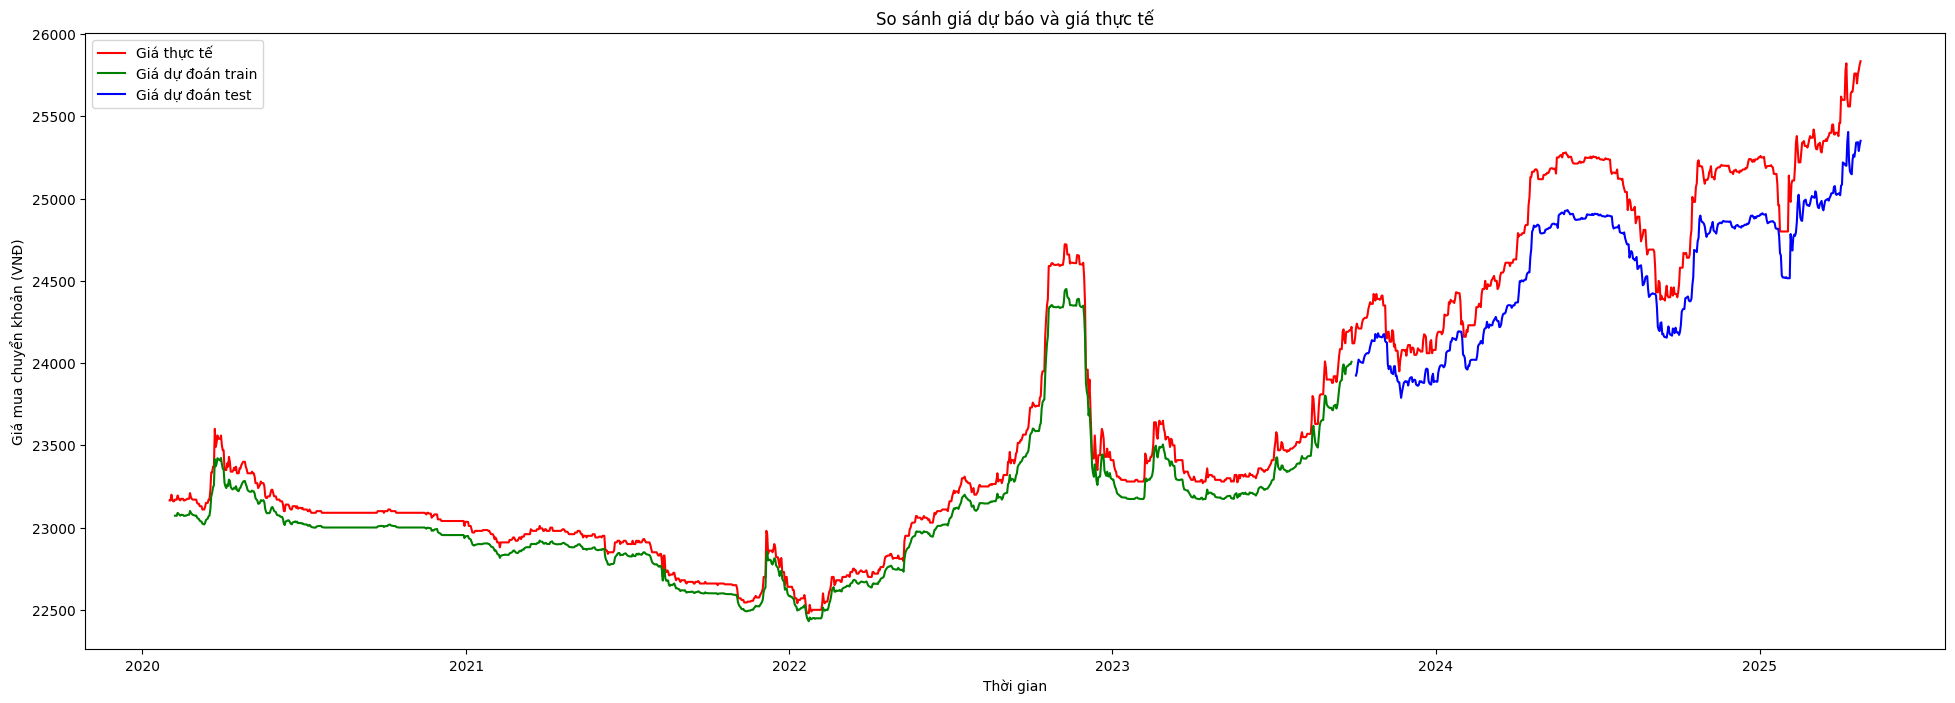

In [23]:
# Xác định 70% dữ liệu làm tập train
train_size = int(len(df_usd_ML) * 0.7)

# Cắt lại cho đúng chiều dài:
train_data1 = df_usd_ML[6:train_size-1].copy()
test_data1 = df_usd_ML[train_size+3:].copy()


print(len(train_data1), len(Y_train_predict))
print(len(test_data1), len(Y_test_predict))

# Cắt dữ liệu dự đoán để khớp với dữ liệu gốc
Y_train_predict = Y_train_predict[:len(train_data1)]
Y_test_predict = Y_test_predict[:len(test_data1)]

# Đảm bảo test_data1 có số lượng dòng khớp với Y_test_predict
test_data1 = test_data1.iloc[:len(Y_test_predict)]

plt.figure(figsize=(24,8))
plt.plot(df_usd_ML, label='Giá thực tế', color='red')  # đường giá thực

# Thêm dữ liệu dự đoán vào train_data1 và test_data1
train_data1["Dự đoán"] = Y_train_predict
plt.plot(train_data1["Dự đoán"], label='Giá dự đoán train', color='green')

test_data1["Dự đoán"] = Y_test_predict
plt.plot(test_data1["Dự đoán"], label='Giá dự đoán test', color='blue')

plt.title('So sánh giá dự báo và giá thực tế')
plt.xlabel('Thời gian')
plt.ylabel('Giá mua chuyển khoản (VNĐ)')
plt.legend()
plt.show()


In [24]:
from tensorflow.keras.models import load_model

# Gọi lại mô hình đã lưu
loaded_model = load_model("./Model/case_2/BiLSTM/model_7030/save_model.hdf5")
# Dự đoán lại trên tập test
Y_test_predict = loaded_model.predict(X_test)
# Đảo chuẩn hóa (inverse transform)
Y_test_predict = sc.inverse_transform(Y_test_predict)

# Tạo bảng so sánh
compare_df = pd.DataFrame({
    "Giá thực tế": Y_test.flatten(),
    "Giá dự đoán": Y_test_predict.flatten()
})

# Làm tròn về số nguyên
compare_df = compare_df.astype(int)
pd.set_option('display.max_rows', None)
# Hiển thị toàn bộ bảng
display(compare_df)
compare_df.to_csv("./Model/case_2/BiLSTM/model_7030/predict.csv", index=False)


18/18 [==============================] - 1s 3ms/step


,Giá thực tế,Giá dự đoán
0,24150,23924
1,24210,23942
2,24240,23988
3,24220,24021
4,24210,24014
5,24210,24006
6,24210,24004
7,24210,24002
8,24245,24001
9,24265,24027
